# 9. _Feature Engineering_ - Etapa 1: _Books_ de variáveis

## 9.1. Book Logs

### 9.1.1. Carregando bases

In [ ]:
silver_path = "C:/Users/Gustavo/Downloads/datamaster/dados/silver"
df_logs_fix = spark.read.parquet(f"{silver_path}/df_logs_fix.parquet")
df_spine = spark.read.parquet(f"{silver_path}/df_spine")

In [ ]:
df_logs_fix.count()

26758971

In [ ]:
df_spine.count()

11242865

In [ ]:
df_logs_fix_spine = df_spine.join(df_logs_fix, ["msno", "safra"], "left")

In [ ]:
df_logs_fix_spine.count()

11242865

In [ ]:
df_logs_fix_spine.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- safra: integer (nullable = true)
 |-- num_25: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- num_75: double (nullable = true)
 |-- num_985: double (nullable = true)
 |-- num_100: double (nullable = true)
 |-- num_unq: double (nullable = true)
 |-- total_secs: double (nullable = true)



### 9.1.2. flag_has_logs

In [ ]:
df_logs_fix_spine = df_logs_fix_spine.withColumn("flag_has_logs", F.when(F.col("total_secs").isNull(), 0).otherwise(1))

### 9.1.3. total_plays

In [ ]:
df_logs_fix_spine = df_logs_fix_spine.withColumn("total_plays", F.col("num_25") + F.col("num_50") + F.col("num_75") + F.col("num_985") + F.col("num_100"))

# Agrupamento por quartis - metodo arriscado: usar os valores brutos do EDA para definir os cortes traz risco para a performance futura,
# dado que a distribuicao dos valores da var pode alterar

# df_logs_fix_spine = df_logs_fix_spine.withColumn("total_plays_group",
#     F.when(F.col("total_plays").isin(0) | F.col("total_plays").isNull(), "00_unknown")\
#     .when(F.col("total_plays").between(1, 164), "01_casual_listener") 
#     .when(F.col("total_plays").between(165, 443), "02_regular_listener") 
#     .when(F.col("total_plays").between(444, 932), "03_frequent_listener") 
#     .otherwise("04_power_user")) 

# Metodo adequado
df_logs_fix_spine = segment_by_percentile(df_logs_fix_spine, "total_plays", "logs")

map_total_plays = {
    "unknown": "00_unknown",
    "tier_1": "01_casual_listener", # Q1 - Usuário que consome pouco, possivelmente esporádico.
    "tier_2": "02_regular_listener", # Q2 - Usuário recorrente, mas com volume moderado.
    "tier_3": "03_frequent_listener", # Q3 - Usuário engajado, consome acima da média.
    "tier_4": "04_power_user" # Q4 - Usuário altamente engajado, possivelmente fã da plataforma.
}

df_logs_fix_spine = df_logs_fix_spine.replace(map_total_plays, subset=["total_plays_group"])

In [ ]:
# Aplicar transformação logarítmica - considerar levar esta como o valor continuo no modelo linear
df_logs_fix_spine = df_logs_fix_spine.withColumn("log_total_plays", F.log1p(F.col("total_plays")))

### 9.1.4. completed_songs_rate

In [ ]:
# Cálculo da taxa de completude com tratamento de divisão por zero
df_logs_fix_spine = df_logs_fix_spine.withColumn("completed_songs_rate",
    F.when(F.col("total_plays") > 0, F.col("num_100") / F.col("total_plays")).otherwise(0.0))

# Agrupamento por quartis - inadequado

# df_logs_fix_spine = df_logs_fix_spine.withColumn("completed_songs_rate_group",
#     F.when(F.col("completed_songs_rate").isin(0) | F.col("completed_songs_rate").isNull(), "00_unknown")
#     .when((F.col("completed_songs_rate") > 0.00) & (F.col("completed_songs_rate") <= 0.477) , "01_bouncer") 
#     .when((F.col("completed_songs_rate") > 0.477) & (F.col("completed_songs_rate") <= 0.694), "02_skipping_listener") 
#     .when((F.col("completed_songs_rate") > 0.694) & (F.col("completed_songs_rate") <= 0.835), "03_engaged_listener") 
#     .otherwise("04_completionist")) 

# Metodo adequado
df_logs_fix_spine = segment_by_percentile(df_logs_fix_spine, "completed_songs_rate", "logs")

map_completion = {
    "unknown": "00_unknown",
    "tier_1": "01_bouncer", # Q1 - Usuário que "pula" musicas rápido (skip rate alto).
    "tier_2": "02_skipping_listener", # Q2 - Ouve partes da música, mas raramente termina.
    "tier_3": "03_engaged_listener", # Q3 - Ouve a maior parte do conteúdo; bom sinal de interesse.
    "tier_4": "04_completionist" # Q4 - Usuário que ouve tudo até o fim.
}

df_logs_fix_spine = df_logs_fix_spine.replace(map_completion, subset=["completed_songs_rate_group"])

### 9.1.5. avg_secs_per_unq

In [ ]:
df_logs_fix_spine = df_logs_fix_spine.withColumn("avg_secs_per_unq", F.when(F.col("num_unq") > 0, F.col("total_secs") / F.col("num_unq")).otherwise(0.0))

# Winsorizar pra cima, no p995 visto no eda - pode trazer problemas de performance. O correto seria colocar o proprio p995

# df_logs_fix_spine = df_logs_fix_spine.withColumn("avg_secs_per_unq_cap",
    # F.when(F.col("avg_secs_per_unq") > 1830, 1830).otherwise(F.col("avg_secs_per_unq")))

# Maneira ideal de cap
p995_secs_per_unq = df_logs_fix_spine.approxQuantile("avg_secs_per_unq", [0.995], 0.001)[0]
df_logs_fix_spine = df_logs_fix_spine.withColumn("avg_secs_per_unq_cap",
    F.when(F.col("avg_secs_per_unq") > p995_secs_per_unq, p995_secs_per_unq).otherwise(F.col("avg_secs_per_unq")))

# Agrupamento por quartis - inadequado 

# df_logs_fix_spine = df_logs_fix_spine.withColumn("avg_secs_per_unq_cap_group",
#     F.when(F.col("avg_secs_per_unq_cap").isin(0) | F.col("avg_secs_per_unq_cap").isNull(), "00_unknown")
#     .when((F.col("avg_secs_per_unq_cap") > 0) & (F.col("avg_secs_per_unq_cap") <= 173.965), "01_skimmer") 
#     .when((F.col("avg_secs_per_unq_cap") > 173.965) & (F.col("avg_secs_per_unq_cap") <= 230.141), "02_sampler") 
#     .when((F.col("avg_secs_per_unq_cap") > 230.141) & (F.col("avg_secs_per_unq_cap") <= 276.917), "03_focused_listener") 
#     .otherwise("04_deep_listener")) 

# Metodo adequado
df_logs_fix_spine = segment_by_percentile(df_logs_fix_spine, "avg_secs_per_unq_cap", "logs")

map_seconds = {
    "unknown": "00_unknown",
    "tier_1": "01_skimmer", # Q1 - O "surfista": ouve apenas o inicio, talvez procurando algo especifico
    "tier_2": "02_sampler", # Q2 - O "degustador": ouve o parte da musica, mas nao a faixa toda
    "tier_3": "03_focused_listener", # Q3 - O usuário padrão: permanece na música durante o tempo core
    "tier_4": "04_deep_listener" # Q4 - O imersivo: ouve faixas completas e provavelmente de generos mais longos.
}

df_logs_fix_spine = df_logs_fix_spine.replace(map_seconds, subset=["avg_secs_per_unq_cap_group"])

In [ ]:
# Aplicar transformação logarítmica - considerar levar esta como o valor continuo no modelo linear
df_logs_fix_spine = df_logs_fix_spine.withColumn("log_avg_secs_per_unq", F.log1p(F.col("avg_secs_per_unq")))

### 9.1.6. plays_per_unq_cap_group

In [ ]:
df_logs_fix_spine = df_logs_fix_spine.withColumn("plays_per_unq", F.when(F.col("num_unq") > 0, F.col("num_100") / F.col("num_unq")).otherwise(0.0))

# Winsorizar pra cima, no p995 visto no eda - nao usar valor bruto

# df_logs_fix_spine = df_logs_fix_spine.withColumn("plays_per_unq_cap",
#     F.when(F.col("plays_per_unq") > 7.14, 7.14).otherwise(F.col("plays_per_unq")))

# Maneira correta de cap
p995_plays_per_unq = df_logs_fix_spine.approxQuantile("plays_per_unq", [0.995], 0.001)[0]
df_logs_fix_spine = df_logs_fix_spine.withColumn("plays_per_unq_cap",
    F.when(F.col("plays_per_unq") > p995_plays_per_unq, p995_plays_per_unq).otherwise(F.col("plays_per_unq")))

# Agrupamento semantico, baseado no EDA: separacao estatistica (percentis) nao faz sentido aqui
df_logs_fix_spine = df_logs_fix_spine.withColumn("plays_per_unq_behavior",
    F.when(F.col("plays_per_unq_cap").isin(0) | F.col("plays_per_unq_cap").isNull(), "00_unknown")
    .when((F.col("plays_per_unq_cap") > 0) & (F.col("plays_per_unq_cap") < 1.1), "01_explorer")
    .when((F.col("plays_per_unq_cap") >= 1.1) & (F.col("plays_per_unq_cap") < 1.5), "02_light_repeat")
    .when((F.col("plays_per_unq_cap") >= 1.5) & (F.col("plays_per_unq_cap") < 3.0), "03_repeat")
    .otherwise("04_heavy_repeat"))

### 9.1.7. agrupadas

In [ ]:
total_logs = df_logs_fix_spine.count()
threshold = 0.01  # para ambas vou considerar 1 % como limite maximo de percentual de distribuicao de categorias: serao colapsadas na categoria 99_others

#### plays_behavior_vs_volume

In [ ]:
df_logs_fix_spine = df_logs_fix_spine.withColumn("plays_behavior_vs_volume", F.concat_ws("_", F.col("plays_per_unq_behavior"), F.col("total_plays_group")))

In [ ]:
freq_table_bhv_vol = df_logs_fix_spine.groupBy("plays_behavior_vs_volume").count()
freq_table_bhv_vol = freq_table_bhv_vol.withColumn("pct", F.col("count") / total_logs)

rare_categories = (freq_table_bhv_vol
    .filter(F.col("pct") < threshold)
    .select("plays_behavior_vs_volume")
    .rdd.flatMap(lambda x: x).collect())

df_logs_fix_spine = df_logs_fix_spine.withColumn("plays_behavior_vs_volume_collapsed",
    F.when(F.col("plays_behavior_vs_volume").isin(rare_categories), "99_other")
    .otherwise(F.col("plays_behavior_vs_volume")))

#### plays_behavior_vs_completion

In [ ]:
df_logs_fix_spine = df_logs_fix_spine.withColumn("plays_behavior_vs_completion", F.concat_ws("_", F.col("plays_per_unq_behavior"), F.col("completed_songs_rate_group")))

In [ ]:
freq_table_bhv_comp = df_logs_fix_spine.groupBy("plays_behavior_vs_completion").count()
freq_table_bhv_comp = freq_table_bhv_comp.withColumn("pct", F.col("count") / total_logs)

rare_categories = (freq_table_bhv_comp
    .filter(F.col("pct") < threshold)
    .select("plays_behavior_vs_completion")
    .rdd.flatMap(lambda x: x).collect())

df_logs_fix_spine = df_logs_fix_spine.withColumn("plays_behavior_vs_completion_collapsed",
    F.when(F.col("plays_behavior_vs_completion").isin(rare_categories), "99_other")
    .otherwise(F.col("plays_behavior_vs_completion")))

### 9.1.8. catalog_exploration_ratio

In [ ]:
df_logs_fix_spine = df_logs_fix_spine.withColumn("catalog_exploration_ratio", F.when(F.col("num_100") > 0, F.col("num_unq") / F.col("num_100")).otherwise(0.0))

# Calcular o p99.5 de catalog_exploration_ratio
p995_value_expl_ratio = df_logs_fix_spine.approxQuantile("catalog_exploration_ratio", [0.995], 0.001)[0]

# # Winsorizar no p99.5
df_logs_fix_spine = df_logs_fix_spine.withColumn("catalog_exploration_ratio_cap",
    F.when(F.col("catalog_exploration_ratio") > p995_value_expl_ratio, p995_value_expl_ratio)
    .otherwise(F.col("catalog_exploration_ratio")))

### 9.1.9. early_drop_rate

In [ ]:
df_logs_fix_spine = df_logs_fix_spine.withColumn("early_drop_rate",
    F.when(F.col("flag_has_logs").isin(1), ((F.col("num_25") + F.col("num_50")) / F.col("total_plays"))).otherwise(0.0))

df_logs_fix_spine = df_logs_fix_spine.withColumn("early_drop_rate_group",
    F.when(F.col("flag_has_logs").isin(0), "00_unknown")
    .when(F.col("early_drop_rate") == 0.0, "01_completionist") # Ouvinte Passivo/Fiel: Ouve 100% do que começa.
    .when(F.col("early_drop_rate") <= 0.20, "02_engaged") # Ouvinte Engajado: Pula até 1 em cada 5 músicas.
    .when(F.col("early_drop_rate") <= 0.5, "03_explorer") # Explorador: Pula entre 20% e 50%. Está ativamente buscando novas músicas ou pulando o que não conhece.
    .otherwise("04_skipping_heavy")) # Skipper Crônico: Pula mais da metade do que começa

### 9.1.10. completion_efficiency

In [ ]:
df_logs_fix_spine = df_logs_fix_spine.withColumn("completion_efficiency",
    F.when(F.col("flag_has_logs").isin(1), (F.col("num_100") / (F.col("num_75") + F.col("num_985") + F.col("num_100")))).otherwise(0.0))

### 9.1.11. flag_shallow_user

In [ ]:
df_logs_fix_spine = df_logs_fix_spine.withColumn("flag_shallow_user", F.when((F.col("num_25") > 0) & (F.col("num_100") == 0), 1).otherwise(0))

### 9.1.12. log_total_secs

A presente variavel sera criada considerando sua aplicacao no modelo linear, o qual se mostra sensivel a alta escala de valores.

In [ ]:
df_logs_fix_spine = df_logs_fix_spine.withColumn("log_total_secs", F.log1p(F.col("total_secs")))

### 9.1.13. features_de_tendencia_num

In [ ]:
selected_vars = [
    # core drivers de custo e marge: representam volume/custo direto
    "num_unq",
    "total_secs",
    "total_plays",
    "log_total_secs",
    "log_total_plays",
    # eficiencias de consumo / engajamento / intensidade media
    "avg_secs_per_unq_cap",
    "plays_per_unq_cap",
    "catalog_exploration_ratio_cap",
    "completion_efficiency",
    "completed_songs_rate",
    "early_drop_rate"
]

df_logs_book = features_de_tendencia_num(df_logs_fix_spine, selected_vars)

As transformações temporais contínuas foram aplicadas apenas a variáveis numéricas que representam intensidade, eficiência ou custo de consumo. Ate considerei inserir as demais variaveis de log brutas (num_n), pois permitem capturar mudanca de padrao na escuta (bom para arvores), mas se mostram altamente colineares entre si (como visto no EDA) e sao redundantes com `early_drop_rate`, `completion_efficiency`.

### 9.1.14. features_de_tendencia_cat

In [ ]:
selected_vars = [
    "flag_has_logs",
    "flag_shallow_user"
]

df_logs_book = features_de_tendencia_cat(df_logs_book, selected_vars)

Considerando que flags mensuram estado, uma transformação temporal de flag serve para responder as perguntas:

* Com que frequência esse estado ocorre ao longo do tempo?
* Esse comportamento é persistente ou pontual?

`flag_xpto`:

* flag_xpto_sum_n  → quantos meses no estado x nos últimos n meses
* flag_xpto_mean_n → frequência de atividade (0–1) nos últimos n meses
* flag_xpto_max_n  → esteve em x ao menos uma vez últimos n meses?

### 9.1.15. Salvar base

In [ ]:
df_logs_book.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- num_25: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- num_75: double (nullable = true)
 |-- num_985: double (nullable = true)
 |-- num_100: double (nullable = true)
 |-- num_unq: double (nullable = true)
 |-- total_secs: double (nullable = true)
 |-- total_plays: double (nullable = true)
 |-- flag_has_logs: integer (nullable = false)
 |-- total_plays_group: string (nullable = false)
 |-- log_total_plays: double (nullable = true)
 |-- completed_songs_rate: double (nullable = true)
 |-- completed_songs_rate_group: string (nullable = false)
 |-- avg_secs_per_unq: double (nullable = true)
 |-- avg_secs_per_unq_cap: double (nullable = true)
 |-- avg_secs_per_unq_cap_group: string (nullable = false)
 |-- log_avg_secs_per_unq: double (nullable = true)
 |-- plays_per_unq: double (nullable = true)
 |-- plays_per_unq_cap: double (nullable = true)
 |-- plays_per_unq_behavior: string (nullable

In [ ]:
# 1. cache
df_logs_book = df_logs_book.persist()
df_logs_book.count()

# 2. salvar particionado
df_logs_book.write \
    .mode("overwrite") \
    .partitionBy("safra") \
    .parquet("C:/Users/Gustavo/Downloads/datamaster/dados/silver/df_logs_book")

### 9.1.16. Testes

In [ ]:
silver_path = "C:/Users/Gustavo/Downloads/datamaster/dados/silver"
df_logs_book = spark.read.parquet(f"{silver_path}/df_logs_book")
df_spine = spark.read.parquet(f"{silver_path}/df_spine")

df_logs_spine = df_spine.join(df_logs_book, ["msno", "safra"], "left")

In [ ]:
df_logs_spine.groupBy("flag_has_logs").count().show()

+-------------+-------+
|flag_has_logs|  count|
+-------------+-------+
|            1|9975880|
|            0|1266985|
+-------------+-------+



## 9.2. Book Transactions

### 9.2.1. Carregando bases

In [ ]:
silver_path = "C:/Users/Gustavo/Downloads/datamaster/dados/silver"
df_transactions_fix = spark.read.parquet(f"{silver_path}/df_transactions_fix.parquet")
df_spine = spark.read.parquet(f"{silver_path}/df_spine")

In [ ]:
df_transactions_fix.count()

20712225

In [ ]:
df_spine.count()

11242865

In [ ]:
df_transactions_fix.printSchema()

root
 |-- msno: string (nullable = true)
 |-- payment_method_id: integer (nullable = true)
 |-- payment_plan_days: integer (nullable = true)
 |-- plan_list_price: float (nullable = true)
 |-- actual_amount_paid: float (nullable = true)
 |-- is_auto_renew: integer (nullable = true)
 |-- transaction_date: date (nullable = true)
 |-- membership_expire_date: date (nullable = true)
 |-- is_cancel: integer (nullable = true)
 |-- safra: integer (nullable = true)
 |-- flag_expire_invalido: integer (nullable = true)



In [ ]:
df_transactions_fix_spine = df_spine.join(df_transactions_fix, ["msno", "safra"], "left")

In [ ]:
df_transactions_fix_spine.count()

11242865

In [ ]:
df_transactions_fix_spine.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- payment_method_id: integer (nullable = true)
 |-- payment_plan_days: integer (nullable = true)
 |-- plan_list_price: float (nullable = true)
 |-- actual_amount_paid: float (nullable = true)
 |-- is_auto_renew: integer (nullable = true)
 |-- transaction_date: date (nullable = true)
 |-- membership_expire_date: date (nullable = true)
 |-- is_cancel: integer (nullable = true)
 |-- flag_expire_invalido: integer (nullable = true)



**Importante**: as variaveis construidas podem sim ter grande correlacao entre si, dando indicios de multicolinearidade. Ressalta-se que, no momento atual, estamos apenas elaborando as variaveis possiveis de serem construidas e que agregam alguma informacao por si so, ou seja, individualmente. A analise da correlacao destas variaveis e melhor escolha de qual delas vai para o modelo final se dara na etapa de _feature selection_.

### 9.2.2. flag_has_transactions_

In [ ]:
df_transactions_fix_spine = df_transactions_fix_spine.withColumn("flag_has_transactions", F.when(F.col("flag_expire_invalido").isNotNull(), 1).otherwise(0))

### 9.2.3. flags de cobranca e pagamento

Descobertas a partir do EDA em `payment_plan_days`

In [ ]:
df_transactions_fix_spine = (df_transactions_fix_spine
    .withColumn("flag_valid_fee", # Flag: cobrança válida (plano real)
        F.when((F.col("payment_plan_days") > 0) & (F.col("plan_list_price") > 0), 1).otherwise(0))
    .withColumn("flag_exemption", # Flag: isenção (nem cobrou nem pagou, sem cancelamento)
        F.when((F.col("actual_amount_paid") == 0) & (F.col("plan_list_price") == 0) & (F.col("is_cancel") == 0), 1).otherwise(0)))

Essas flags explicam anomalias de receita, algo que o modelo não aprende só olhando valores contínuos.

### 9.2.4. indicadores de compromisso / estabilidade

In [ ]:
df_transactions_fix_spine = df_transactions_fix_spine.withColumn("flag_plano_mensal", F.when(F.col("payment_plan_days").isin([30, 31]), 1).otherwise(0))

In [ ]:
df_transactions_fix_spine = df_transactions_fix_spine.withColumn("daily_revenue_efficiency", # Eficiência de receita diária
        F.when(F.col("payment_plan_days") > 0, F.col("actual_amount_paid") / F.col("payment_plan_days")).otherwise(F.col("actual_amount_paid")))

df_transactions_fix_spine = df_transactions_fix_spine.withColumn("revenue_tier",
    F.when(F.col("flag_has_transactions").isin(0), "00_unknown") # Sem transação
    .when(F.col("daily_revenue_efficiency") == 0, "01_free_isencao") # Isenções/vouchers
    .when(F.col("daily_revenue_efficiency") < 3.0, "02_low_tier") # Planos residuais/testes
    .when(F.col("daily_revenue_efficiency").between(3.0, 3.5), "03_standard_99") # Plano básico (R$ 99/mês)
    .when(F.col("daily_revenue_efficiency").between(4.5, 5.5), "04_premium_149") # Plano mais popular (R$ 149/mês)
    .when(F.col("daily_revenue_efficiency") > 5.5, "05_high_tier") # Planos premium (R$ 180+)
    .otherwise("06_others")) # Planos especiais/promocionais

### 9.2.5. grupo de método de pagamento

Baseado na dependência forte entre `payment_method_id` e `is_auto_renew`.

In [ ]:
df_payment_method_group = (df_transactions_fix_spine
    .groupBy("payment_method_id")
    .agg(F.mean("is_auto_renew").alias("pct_auto_renew"))
    .withColumn("payment_method_group",
        F.when(F.col("pct_auto_renew").isNull(), "00_no_transaction")
        .when(F.col("pct_auto_renew") >= 0.90, "01_most_auto")
        .when(F.col("pct_auto_renew") >= 0.30, "02_mixed")
        .otherwise("03_most_manual"))
    .select("payment_method_id", "payment_method_group"))

df_transactions_fix_spine = (df_transactions_fix_spine.join(df_payment_method_group, "payment_method_id", "left"))

df_transactions_fix_spine = df_transactions_fix_spine.withColumn("payment_method_group",
    F.when(F.col("payment_method_group").isNull(), "00_no_transaction").otherwise(F.col("payment_method_group")))

* Remove quase-colinearidade em regressão

* Preserva sinal comportamental

* Facilita storytelling de negócio

### 9.2.6. payment_price_regime

Baseada na diferenca de pagamentos

In [ ]:
df_transactions_fix_spine = df_transactions_fix_spine.withColumn("payment_price_regime",
    F.when(F.col("plan_list_price").isNull(), "00_no_transaction")
    .when((F.col("plan_list_price") > 0) & (F.col("actual_amount_paid") == F.col("plan_list_price")), "01_paid_as_expected")
    .otherwise("02_irregular_payment"))

### 9.2.7. features_de_tendencia_num

In [ ]:
selected_vars = [
    "daily_revenue_efficiency",
]

df_transactions_book = features_de_tendencia_num(df_transactions_fix_spine, selected_vars)

A `daily_revenue_efficiency` é o termômetro financeiro do cliente. Transformá-la temporalmente permite ao modelo distinguir entre:

* Estabilidade: Um cliente que mantém a mesma eficiência diária há 6 meses (perfil fiel);
* Degradação: Um cliente que teve uma queda na eficiência (ex: mudou de um plano Premium para um Standard ou promocional), o que impacta diretamente a margem futura;
* Volatilidade: Clientes que alternam entre meses pagos e meses gratuitos (isenção), sinalizando instabilidade financeira.

### 9.2.8. features_de_tendencia_cat

In [ ]:
selected_flags = [
    "flag_has_transactions",
    "flag_valid_fee",
    "flag_exemption",
    "flag_plano_mensal",
    "flag_expire_invalido",
]

df_transactions_book = features_de_tendencia_cat(df_transactions_book, selected_flags)

Para as flags, a transformação temporal não busca "média", mas sim persistência e frequência.

- `flag_has_transactions`

Motivo: Criar a Taxa de Adimplência. Um mean_6 de 1.0 indica um pagador perfeito; um mean_6 de 0.5 indica um cliente que paga apenas metade do tempo. É o preditor mais forte de margem futura;

- `flag_valid_fee` & `flag_exemption`

Motivo: Identificar o Perfil de Custo de Aquisição. Usuários que vivem de isenções (flag_exemption) de forma recorrente têm um LTV (Lifetime Value) muito menor. A recorrência dessas flags ajuda a separar o "usuário oportunista" do "usuário pagador";

- `flag_plano_mensal`:

Motivo: Medir a Fidelidade ao Modelo de Assinatura. A mudança de um plano mensal para um plano de outra duração (ou a interrupção do mensal) é um sinal clássico de alteração no comportamento de retenção.

- `flag_expire_invalido`:

Motivo: Capturar Ruído Operacional Recorrente. Se essa flag aparece com frequência para um usuário, pode indicar problemas técnicos na conta ou tentativas de fraude, ambos correlacionados com instabilidade de margem.

### 9.2.10. Salvar base

In [ ]:
df_transactions_book.printSchema()

root
 |-- payment_method_id: integer (nullable = true)
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- payment_plan_days: integer (nullable = true)
 |-- plan_list_price: float (nullable = true)
 |-- actual_amount_paid: float (nullable = true)
 |-- is_auto_renew: integer (nullable = true)
 |-- transaction_date: date (nullable = true)
 |-- membership_expire_date: date (nullable = true)
 |-- is_cancel: integer (nullable = true)
 |-- flag_expire_invalido: integer (nullable = true)
 |-- flag_has_transactions: integer (nullable = false)
 |-- flag_valid_fee: integer (nullable = false)
 |-- flag_exemption: integer (nullable = false)
 |-- flag_plano_mensal: integer (nullable = false)
 |-- daily_revenue_efficiency: double (nullable = true)
 |-- revenue_tier: string (nullable = false)
 |-- payment_method_group: string (nullable = true)
 |-- payment_price_regime: string (nullable = false)
 |-- daily_revenue_efficiency_raw: double (nullable = true)
 |-- daily_revenue_

In [ ]:
# 1. cache
df_transactions_book = df_transactions_book.persist()
df_transactions_book.count()

# 2. salvar particionado
df_transactions_book.write \
    .mode("overwrite") \
    .partitionBy("safra") \
    .parquet("C:/Users/Gustavo/Downloads/datamaster/dados/silver/df_transactions_book")

## 9.3. Book Members

### 9.3.1. Carregando bases

In [ ]:
silver_path = "C:/Users/Gustavo/Downloads/datamaster/dados/silver"
df_members_fix = spark.read.parquet(f"{silver_path}/df_members_fix.parquet")
df_spine = spark.read.parquet(f"{silver_path}/df_spine")

In [ ]:
df_members_fix.count()

63867246

In [ ]:
df_spine.count()

11242865

In [ ]:
df_members_fix.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: string (nullable = true)
 |-- registration_init_time: date (nullable = true)
 |-- city: integer (nullable = true)
 |-- bd: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- registered_via: integer (nullable = true)
 |-- is_ativo: integer (nullable = true)
 |-- flag_idade_invalida: integer (nullable = true)
 |-- idade_clean: integer (nullable = true)
 |-- gender_clean: string (nullable = true)



In [ ]:
df_members_fix_spine = df_spine.join(df_members_fix, ["msno", "safra"], "left")

In [ ]:
df_members_fix_spine.count()

11242865

In [ ]:
df_members_fix_spine.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- registration_init_time: date (nullable = true)
 |-- city: integer (nullable = true)
 |-- bd: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- registered_via: integer (nullable = true)
 |-- is_ativo: integer (nullable = true)
 |-- flag_idade_invalida: integer (nullable = true)
 |-- idade_clean: integer (nullable = true)
 |-- gender_clean: string (nullable = true)



### 9.3.2. faixa_idade

In [ ]:
df_members_book = df_members_fix_spine.withColumn("faixa_idade",
    F.when(F.col("flag_idade_invalida") == 1, "Desconhecido")
        .when((F.col("idade_clean") >= 16) & (F.col("idade_clean") <= 22), "16-22")
        .when((F.col("idade_clean") >= 23) & (F.col("idade_clean") <= 34), "23-34")
        .when((F.col("idade_clean") >= 35) & (F.col("idade_clean") <= 52), "35-52")
        .otherwise("53+"))

### 9.3.3. flags for city and gender

#### city

In [ ]:
df_members_book = df_members_book.withColumn("flag_city_one",F.when(F.col("city").isin(1), 1).otherwise(0))

#### gender

In [ ]:
df_members_book = df_members_book.drop("gender")

In [ ]:
df_members_book = df_members_book.withColumn("flag_gender_known", F.when(F.col("gender_clean") != "unknown", 1).otherwise(0))

### 9.3.4. registered_via

#### flag

In [ ]:
df_members_book = df_members_book.withColumn("flag_high_value_registered_via",F.when(F.col("registered_via").isin(3, 9), 1).otherwise(0))

#### grouped

In [ ]:
df_members_book = df_members_book.withColumn("registered_via_group",
    F.when(F.col("registered_via").isin(3, 9), "high_value")
    .when(F.col("registered_via") == 7, "low_value")
    .when(F.col("registered_via") == 4, "mid_value")
    .otherwise("other"))

### 9.3.5. registration_year_regime

In [ ]:
df_members_book = df_members_book.withColumn("ano_registro", F.year("registration_init_time"))

df_members_book = df_members_book.withColumn("registration_year_regime",
    F.when(F.col("ano_registro").isin([2004, 2005, 2006, 2007, 2008, 2009]), "2004-2009")\
    .when(F.col("ano_registro").isin([2010, 2011, 2012, 2013, 2014]), "2010-2014")\
    .otherwise("2015+"))

df_members_book = df_members_book.drop("ano_registro")

### 9.3.6. tenure

#### continuo

In [ ]:
df_members_book = df_members_book.withColumn("safra_date", F.to_date(F.concat(F.col("safra").cast("string"), F.lit("01")), "yyyyMMdd"))

df_members_book = (df_members_book
    .withColumn("tenure_meses", F.floor(F.months_between("safra_date", "registration_init_time")))
    .withColumn("tenure_meses", F.when(F.col("tenure_meses") < 0, 0).otherwise(F.col("tenure_meses"))))

df_members_book = df_members_book.drop("safra_date")

#### flag + faixa

In [ ]:
df_members_book = df_members_book.withColumn("flag_long_tenure", F.when(F.col("tenure_meses") >= 36, 1).otherwise(0))

In [ ]:
df_members_book = df_members_book.withColumn("tenure_faixa",
    F.when(F.col("tenure_meses").isNull(), "00_unknown")
     .when((F.col("tenure_meses") >= 0) & (F.col("tenure_meses") <= 11), "01_0-11months")
     .when((F.col("tenure_meses") >= 12) & (F.col("tenure_meses") <= 35), "02_12-35months")
    .otherwise("03_36+months"))

### 9.3.7. features_de_tendencia

Para as variaveis em questao, compreendo que nenhuma transformacao seja necessaria, pois como observado no EDA, a unica variavel que pode variar com o tempo seria `tenure_meses`, a qual nao faz sentido capturar tendencia. As demais nao se alteraram ao longo do tempo pelo que foi analisado ate entao, e mesmo que possam eventualmente se alterar quando o modelo for implantado em producao, uma vez nao tendo diferenca entre as flags durante o treino, as variaveis seriam naturalmente "iguais". Poderiamos ate supor que as variaveis de tendencia dos ultimos n meses trariam informacoes mais valiosas, uma vez que consiste em revelar habitos e nao um unico momento em especifico, mas ainda assim, optei por seguir sem transformacoes de tendencia.

### 9.3.8. Salvar base

In [ ]:
df_members_book.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- registration_init_time: date (nullable = true)
 |-- city: integer (nullable = true)
 |-- bd: integer (nullable = true)
 |-- registered_via: integer (nullable = true)
 |-- is_ativo: integer (nullable = true)
 |-- flag_idade_invalida: integer (nullable = true)
 |-- idade_clean: integer (nullable = true)
 |-- gender_clean: string (nullable = true)
 |-- faixa_idade: string (nullable = false)
 |-- flag_city_one: integer (nullable = false)
 |-- flag_gender_known: integer (nullable = false)
 |-- flag_high_value_registered_via: integer (nullable = false)
 |-- registered_via_group: string (nullable = false)
 |-- registration_year_regime: string (nullable = false)
 |-- tenure_meses: long (nullable = true)
 |-- flag_long_tenure: integer (nullable = false)
 |-- tenure_faixa: string (nullable = false)



In [ ]:
# 1. cache
df_members_book = df_members_book.persist()
df_members_book.count()

# 2. salvar particionado
df_members_book.write \
    .mode("overwrite") \
    .partitionBy("safra") \
    .parquet("C:/Users/Gustavo/Downloads/datamaster/dados/silver/df_members_book")

# 10. _Feature Engineering_ - Etapa 2: _Cross-Domain Features_

Para capturar a complexidade da relação entre custo e receita, foram desenvolvidas _features_ que cruzam os domínios de Logs, Transactions e Members. Diferente das isoladas, as _cross-features_ permitem identificar perfis comportamentais específicos, como o 'Assinante Fantasma' (alta adimplência com baixo uso) e o 'Explorador de Isenções' (alto consumo de catálogo com baixa recorrência de pagamento).

O uso de componentes já transformados por tendências temporais (como médias de 3/6 meses) nessas fórmulas garante que as variáveis resultantes reflitam a estabilidade do comportamento do usuário, reduzindo a volatilidade do modelo e aumentando sua robustez em cenários de produção.

## 10.1. Carregando e juntando spine + books

In [ ]:
silver_path = "C:/Users/Gustavo/Downloads/datamaster/dados/silver"

df_spine = spark.read.parquet(f"{silver_path}/df_spine")
df_logs_book = spark.read.parquet(f"{silver_path}/df_logs_book")
df_transactions_book = spark.read.parquet(f"{silver_path}/df_transactions_book")
df_members_book = spark.read.parquet(f"{silver_path}/df_members_book")

In [ ]:
df_spine.count()

11242865

In [ ]:
df_final_vars = df_spine.join(df_logs_book, ["msno", "safra"], "left") \
    .join(df_transactions_book, ["msno", "safra"], "left") \
    .join(df_members_book, ["msno", "safra"], "left")

In [ ]:
df_final_vars.count()

11242865

In [ ]:
df_final_vars.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- num_25: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- num_75: double (nullable = true)
 |-- num_985: double (nullable = true)
 |-- num_100: double (nullable = true)
 |-- num_unq: double (nullable = true)
 |-- total_secs: double (nullable = true)
 |-- total_plays: double (nullable = true)
 |-- flag_has_logs: integer (nullable = true)
 |-- total_plays_group: string (nullable = true)
 |-- log_total_plays: double (nullable = true)
 |-- completed_songs_rate: double (nullable = true)
 |-- completed_songs_rate_group: string (nullable = true)
 |-- avg_secs_per_unq: double (nullable = true)
 |-- avg_secs_per_unq_cap: double (nullable = true)
 |-- avg_secs_per_unq_cap_group: string (nullable = true)
 |-- log_avg_secs_per_unq: double (nullable = true)
 |-- plays_per_unq: double (nullable = true)
 |-- plays_per_unq_cap: double (nullable = true)
 |-- plays_per_unq_behavior: string (nullable = t

### Testes

In [ ]:
df_final_vars.groupBy("flag_has_logs").count().show()

+-------------+-------+
|flag_has_logs|  count|
+-------------+-------+
|            1|9975880|
|            0|1266985|
+-------------+-------+



In [ ]:
df_final_vars.groupBy("flag_has_transactions").count().show()

+---------------------+-------+
|flag_has_transactions|  count|
+---------------------+-------+
|                    1|9390483|
|                    0|1852382|
+---------------------+-------+



In [ ]:
df_final_vars.groupBy("plays_per_unq_behavior").count().show()

+----------------------+-------+
|plays_per_unq_behavior|  count|
+----------------------+-------+
|       02_light_repeat|1470819|
|            00_unknown|1409847|
|             03_repeat| 665352|
|           01_explorer|7491601|
|       04_heavy_repeat| 205246|
+----------------------+-------+



Os joins foram corretos, aparentemente nao tem casos de nulos mais.

## 10.2. Margem líquida + target

In [ ]:
v_paid = F.coalesce(F.col("actual_amount_paid"), F.lit(0))
v_unq = F.coalesce(F.col("num_unq"), F.lit(0))
v_secs = F.coalesce(F.col("total_secs"), F.lit(0))

# Custo fixo e variável
custo_variavel = (0.0051 * v_unq) + (0.0001 * v_secs)
custo_total = 50 + custo_variavel

df_final_vars = df_final_vars.withColumn("margem_liquida_mensal",
    F.when( F.col("actual_amount_paid").isNull() & F.col("num_unq").isNull() & F.col("total_secs").isNull(), F.lit(-50)).otherwise(v_paid - custo_total))

w = Window.partitionBy("msno").orderBy("safra")
# Target: margem do mês seguinte
df_final_vars = df_final_vars.withColumn("target", F.lead("margem_liquida_mensal", 1).over(w))

df_final_vars = aplicar_winsorizacao(df_final_vars, ["target"])

Coluna target: Limite Inferior=-108.81472219999999, Limite Superior=129.0401291


## 10.3. revenue_per_hour_listened

### 10.3.1. Definição

Eficiência de Custo por Engajamento. Responde à pergunta: "Quanto de receita diária o usuário gera por hora de conteúdo consumido?"

$$
\text{revenue\_per\_hour\_listened} = \frac{\text{daily\_revenue\_efficiency\_mean\_3}}{\left(\frac{\text{total\_secs\_mean\_3}}{3600}\right) + 1}
$$

- **Numerador:** `daily_revenue_efficiency_mean_3` representa a receita diária média dos últimos 3 meses (NTD/dia).
- **Denominador:** `total_secs_mean_3 / 3600` converte segundos em horas. O `+1` serve como:

  1. Proteção contra divisão por zero: Usuários sem logs (total_secs = 0) teriam denominador indefinido;
  2. Regularização: Evita explosão do ratio para usuários com consumo muito baixo (ex: 10 segundos);
  3. Interpretação: O denominador mínimo de 1 hora garante que a métrica seja sempre bem-definida.

**Interpretação de Valores**

| Valor | Perfil | Impacto na Margem |
|-------|--------|-------------------|
| **Alto (>5.0)** | Assinante Fantasma: paga bem e usa pouco | 🟢 Margem Líquida Máxima |
| **Médio (2.0-5.0)** | Usuário Equilibrado | 🟡 Margem Saudável |
| **Baixo (<2.0)** | Heavy User: consome muito em relação ao que paga | 🔴 Margem Comprimida/Risco |

### 10.3.2. Construção

In [ ]:
df_final_vars = df_final_vars.withColumn("revenue_per_hour_listened",
    F.when((F.col("daily_revenue_efficiency_mean_3") >= 0) & (F.col("total_secs_mean_3") >= 0), # Tratamento para o caso dos códigos sentinela desenvolvidos (ex.: -99999)
        F.col("daily_revenue_efficiency_mean_3") / ((F.col("total_secs_mean_3") / 3600.0) + 1))
    .otherwise(None))

### 10.3.3. "_Fast EDA_" - Checagem rapida para validar a variavel

#### Descritivas + Correlação

In [ ]:
df_final_vars.select("revenue_per_hour_listened").summary("count", "mean", "stddev", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+-------------------------+
|summary|revenue_per_hour_listened|
+-------+-------------------------+
|  count|                  7595681|
|   mean|      0.39007977080327977|
| stddev|       1.2629436194802681|
|    min|     9.222850774873949E-4|
|     1%|      0.02081915265478148|
|     5%|      0.03671249556477943|
|    25%|      0.09127676276173609|
|    50%|      0.17973124027703918|
|    75%|       0.4013412952209249|
|    95%|        1.483265136015288|
|  99.5%|       3.2654715105873966|
|    max|        715.2211255314578|
+-------+-------------------------+



In [ ]:
df_final_vars.select("revenue_per_hour_listened", "target").corr("revenue_per_hour_listened", "target")

0.0655314249010374

In [ ]:
df_final_vars.select("revenue_per_hour_listened", "target_win").corr("revenue_per_hour_listened", "target_win")

0.09807103374416482

Aproximadamente 32% dos registros continham códigos sentinela negativos provenientes da ausência de histórico de receita válido (`daily_revenue_efficiency_mean_3`). A variável presentou uma distribuição estável (média = 0.39, stddev = 1.26) com correlação moderada com a target winsorizada. A correlação relativamente baixa reflete a natureza não-linear da relação entre receita por hora e margem líquida, que depende também da exploração de catálogo (`num_unq`).

#### Testes para tratamentos finais

**Agrupamento**

In [ ]:
df_teste = df_final_vars.select("msno", "safra", "revenue_per_hour_listened", "target_win").withColumn("revenue_per_hour_tier",
    F.when(F.col("revenue_per_hour_listened").isNull(), "00_unknown")
    .when(F.col("revenue_per_hour_listened") < 0.1, "01_very_low")
    .when(F.col("revenue_per_hour_listened") < 0.3, "02_low")
    .when(F.col("revenue_per_hour_listened") < 0.6, "03_medium")
    .when(F.col("revenue_per_hour_listened") < 1.5, "04_high")
    .otherwise("05_very_high"))

In [ ]:
calcular_distribuicao(df_teste, ["revenue_per_hour_tier"])

+---------------------+-------+---------+
|revenue_per_hour_tier|total  |pct_total|
+---------------------+-------+---------+
|00_unknown           |3647184|32.44    |
|02_low               |2964952|26.37    |
|01_very_low          |2136040|19.0     |
|03_medium            |1242019|11.05    |
|04_high              |879350 |7.82     |
|05_very_high         |373320 |3.32     |
+---------------------+-------+---------+



DataFrame[revenue_per_hour_tier: string, total: bigint, pct_total: double]

Processando estatísticas para: revenue_per_hour_tier...


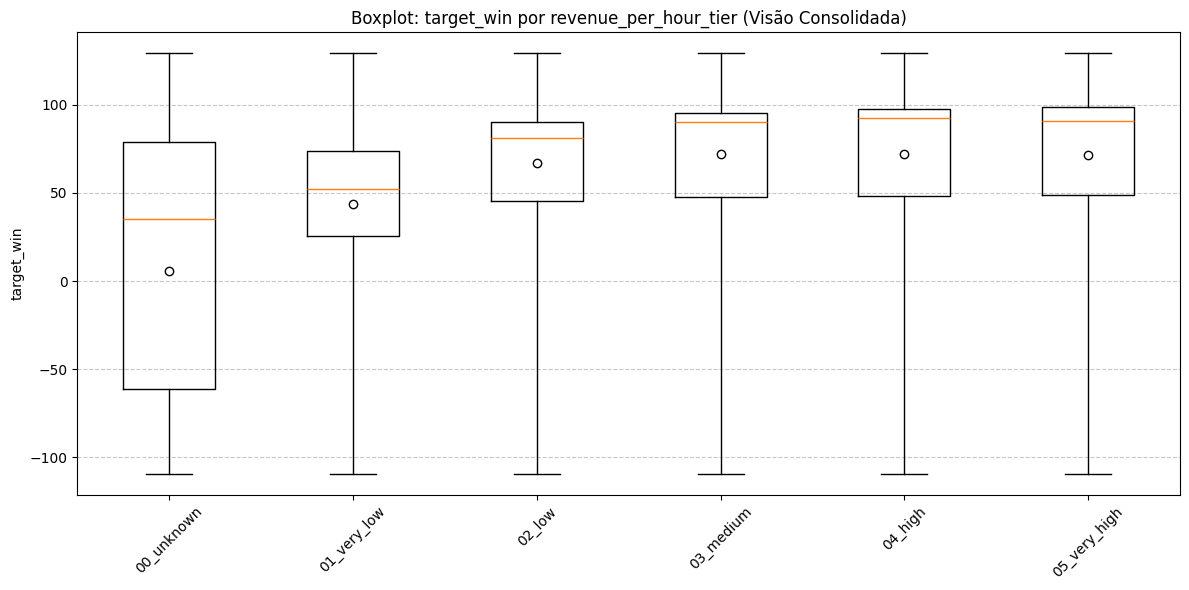


--- Estatísticas: revenue_per_hour_tier (Visão Consolidada) ---


,revenue_per_hour_tier,min,q1,med,mean,q3,max
0,00_unknown,-109.315469,-61.191562,35.243518,5.913455,79.000000,129.051366
3,01_very_low,-109.315469,25.736726,52.302961,43.546908,73.855340,129.051366
4,02_low,-109.315469,45.247835,81.004225,66.663018,90.271398,129.051366
1,03_medium,-109.315469,47.378830,89.883936,71.910907,95.488236,129.051366
2,04_high,-109.315469,48.322100,92.163950,72.274097,97.469390,129.051366
5,05_very_high,-109.315469,48.928189,90.974603,71.364724,98.642785,129.051366


In [ ]:
plot_boxplot(df_teste, ["revenue_per_hour_tier"], "target_win", agrupar_por_safra=False, table=True)

In [ ]:
df_teste = df_teste.withColumn("revenue_per_hour_tier",
    F.when(F.col("revenue_per_hour_listened").isNull(), "00_unknown")
    .when(F.col("revenue_per_hour_listened") < 0.3, "01_low")
    .when(F.col("revenue_per_hour_listened") < 0.6, "02_medium")
    .otherwise("03_high"))

In [ ]:
calcular_distribuicao(df_teste, ["revenue_per_hour_tier"])

+---------------------+-------+---------+
|revenue_per_hour_tier|total  |pct_total|
+---------------------+-------+---------+
|01_low               |5100992|45.37    |
|00_unknown           |3647184|32.44    |
|03_high              |1252670|11.14    |
|02_medium            |1242019|11.05    |
+---------------------+-------+---------+



DataFrame[revenue_per_hour_tier: string, total: bigint, pct_total: double]

Processando estatísticas para: revenue_per_hour_tier...


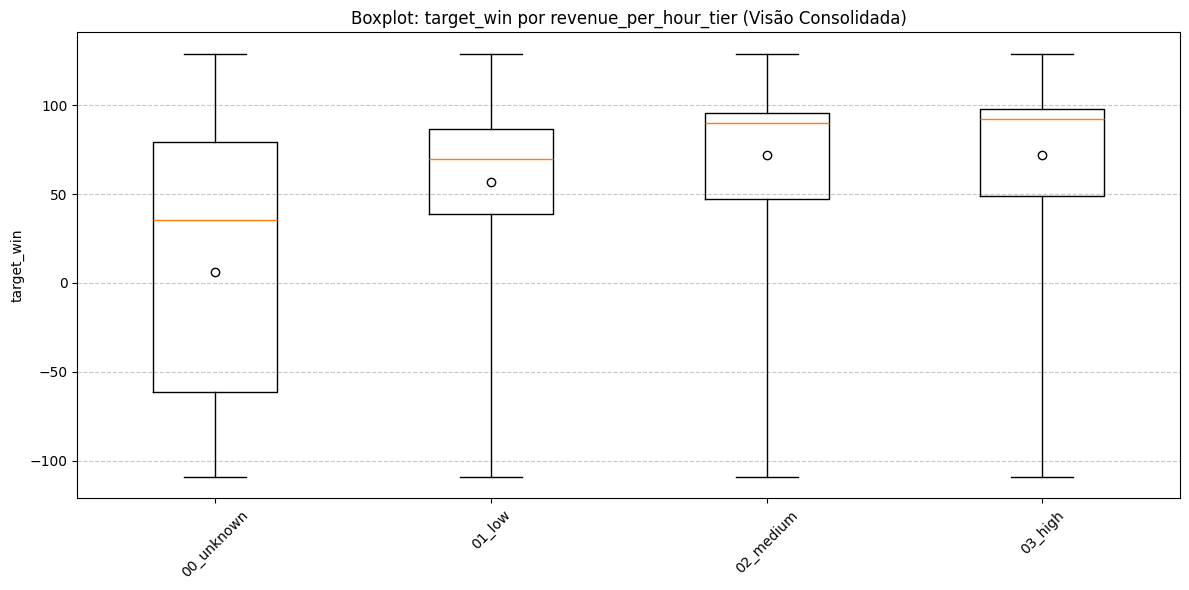


--- Estatísticas: revenue_per_hour_tier (Visão Consolidada) ---


,revenue_per_hour_tier,min,q1,med,mean,q3,max
2,00_unknown,-109.315469,-61.191562,35.243518,5.913455,79.000000,129.051366
0,01_low,-109.315469,38.996684,69.701271,56.992275,86.578686,129.051366
1,02_medium,-109.315469,47.378830,89.883936,71.910907,95.488236,129.051366
3,03_high,-109.315469,48.613136,92.062052,72.002942,97.911087,129.051366


In [ ]:
plot_boxplot(df_teste, ["revenue_per_hour_tier"], "target_win", agrupar_por_safra=False, table=True)

In [ ]:
df_teste = df_teste.withColumn("revenue_per_hour_tier",
    F.when(F.col("revenue_per_hour_listened").isNull(), "00_unknown")
    .when(F.col("revenue_per_hour_listened") < 0.1, "01_low")
    .when(F.col("revenue_per_hour_listened") < 0.3, "02_medium")
    .otherwise("03_high"))

In [ ]:
calcular_distribuicao(df_teste, ["revenue_per_hour_tier"])

+---------------------+-------+---------+
|revenue_per_hour_tier|total  |pct_total|
+---------------------+-------+---------+
|00_unknown           |3647184|32.44    |
|02_medium            |2964952|26.37    |
|03_high              |2494689|22.19    |
|01_low               |2136040|19.0     |
+---------------------+-------+---------+



DataFrame[revenue_per_hour_tier: string, total: bigint, pct_total: double]

Processando estatísticas para: revenue_per_hour_tier...


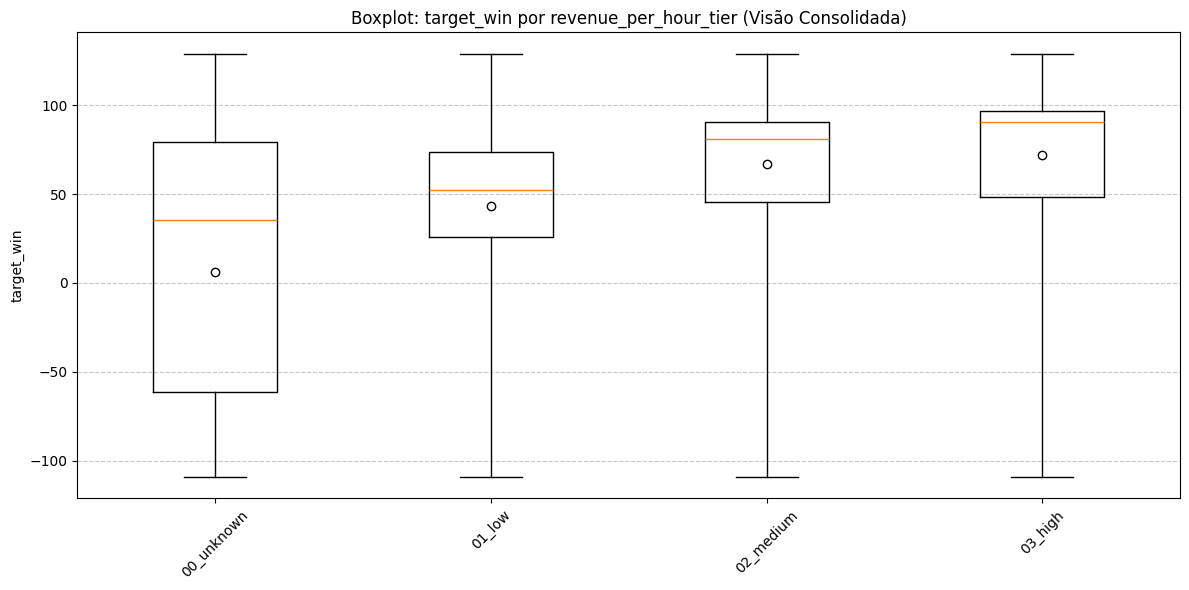


--- Estatísticas: revenue_per_hour_tier (Visão Consolidada) ---


,revenue_per_hour_tier,min,q1,med,mean,q3,max
2,00_unknown,-109.315469,-61.191562,35.243518,5.913455,79.000000,129.051366
0,01_low,-109.315469,25.736726,52.302961,43.546908,73.855340,129.051366
1,02_medium,-109.315469,45.247835,81.004225,66.663018,90.271398,129.051366
3,03_high,-109.315469,48.271231,90.449188,71.957152,96.941563,129.051366


In [ ]:
plot_boxplot(df_teste, ["revenue_per_hour_tier"], "target_win", agrupar_por_safra=False, table=True)

A categorização da eficiência de receita por hora provou ser um discriminador robusto de lucratividade. A análise dos tiers revelou uma progressão não-linear na margem líquida, com o tier 03_high apresentando uma mediana de margem 72% superior ao tier 01_low (90.44 vs 52.30).

O grupo 00_unknown (usuários sem histórico de receita válido) foi identificado como o segmento de maior risco, apresentando a menor média de margem (5.91), o que justifica sua manutenção como uma categoria distinta para capturar o comportamento de usuários inadimplentes ou sem transações.

### 10.3.4. Conclusao

In [ ]:
# Winsorizar pra cima, no p995 - nao usar valor bruto
p995_rev_per_hour = df_final_vars.approxQuantile("revenue_per_hour_listened", [0.995], 0.001)[0]
df_final_vars = df_final_vars.withColumn("revenue_per_hour_listened_cap",
    F.when(F.col("revenue_per_hour_listened") > p995_rev_per_hour, p995_rev_per_hour).otherwise(F.col("revenue_per_hour_listened")))

# Tratar os casos de nulos
df_final_vars = df_final_vars.withColumn("revenue_per_hour_listened_cap",
    F.when(F.col("revenue_per_hour_listened_cap").isNull(), 0.0).otherwise(F.col("revenue_per_hour_listened_cap")))

In [ ]:
df_final_vars = df_final_vars.withColumn("revenue_per_hour_tier",
    F.when(F.col("revenue_per_hour_listened").isNull(), "00_unknown")
    .when(F.col("revenue_per_hour_listened") < 0.1, "01_low")
    .when(F.col("revenue_per_hour_listened") < 0.3, "02_medium")
    .otherwise("03_high"))

df_final_vars = df_final_vars.drop("revenue_per_hour_listened")

## 10.4. exemption_exploitation_index

### 10.4.1. Definição

Índice de Aproveitamento de Isenção.  identifica o **"Usuário Explorador Gratuito"** através da interação entre:
- **Fator 1:** `flag_exemption_mean_6` = Taxa de meses com isenção nos últimos 6 meses (0 a 1).
- **Fator 2:** `catalog_exploration_ratio_cap_mean_3` = Intensidade de exploração de catálogo (músicas únicas / músicas completadas)

$$
\text{exemption\_exploitation\_index} = \text{flag\_exemption\_mean\_6} \times \text{catalog\_exploration\_ratio\_cap\_mean\_3}
$$

O produto (em vez de soma ou ratio) captura a interação não-linear:
- Se `flag_exemption_mean_6 ≈ 0` (usuário pagante regular), o índice zera independentemente da exploração.
- Se `flag_exemption_mean_6 ≈ 1` (usuário com isenções recorrentes), o índice reflete diretamente a exploração de catálogo.

| Valor | Perfil | Impacto na Margem |
|-------|--------|-------------------|
| **Alto (>3.0)** | Explorador de Isenções: descobre muitas músicas sem pagar | 🔴 Alto Custo Variável (`num_unq`), Receita Zero |
| **Médio (1.0-3.0)** | Isenção Ocasional com Uso Moderado | 🟡 Risco Moderado |
| **Baixo (<1.0)** | Pagante Regular ou Isento com Baixo Uso | 🟢 Baixo Risco |

### 10.4.2. Construção

In [ ]:
df_final_vars = df_final_vars.withColumn("exemption_exploitation_index",
    F.when((F.col("flag_exemption_mean_6") >= 0) & (F.col("flag_exemption_mean_6") <= 1) &  # Garantir que é uma proporção válida
        (F.col("catalog_exploration_ratio_cap_mean_3") >= 0),  # Garantir que é positivo
        F.col("flag_exemption_mean_6") * F.col("catalog_exploration_ratio_cap_mean_3"))
    .otherwise(None))  # Casos inválidos viram null

### 10.4.3. "_Fast EDA_"

#### Descritivas + Correlação

In [ ]:
df_final_vars.select("exemption_exploitation_index").summary("count", "mean", "stddev", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+----------------------------+
|summary|exemption_exploitation_index|
+-------+----------------------------+
|  count|                     7705254|
|   mean|        0.008924474607944327|
| stddev|         0.07440198111705876|
|    min|                         0.0|
|     1%|                         0.0|
|     5%|                         0.0|
|    25%|                         0.0|
|    50%|                         0.0|
|    75%|                         0.0|
|    95%|                         0.0|
|  99.5%|         0.41274008257045414|
|    max|          10.152116402116404|
+-------+----------------------------+



In [ ]:
df_final_vars.select("exemption_exploitation_index", "target").corr("exemption_exploitation_index", "target")

-0.028446912366603884

In [ ]:
df_final_vars.select("exemption_exploitation_index", "target_win").corr("exemption_exploitation_index", "target_win")

-0.03997726904790445

O sinal negativo faz sentido (isenção = menos margem), mas a magnitude é irrelevante.

### 10.4.4. Conclusao

A hipótese original era boa: "usuários com isenção recorrente que exploram muito catálogo são caros". Mas na prática pouquíssimos usuários têm isenção recorrente (flag_exemption_mean_6 > 0), então o produto vira zero para 95% da base. Os 5% restantes não têm poder estatístico suficiente para mover a correlação. Descartar.

In [ ]:
df_final_vars = df_final_vars.drop("exemption_exploitation_index")

## 10.5. usage_intensity_per_tenure

### 10.5.1. Definição

Intensidade de Uso por Maturidade. Normaliza o volume de _plays_ recente pelo tempo de vida do cliente, respondendo: "Qual a intensidade de uso mensal ajustada pela maturidade do cliente?"

$$
\text{usage\_intensity\_per\_tenure} = \frac{\text{total\_plays\_mean\_3}}{\text{tenure\_meses} + 1}
$$

- **Numerador:** `total_plays_mean_3` = Média de plays dos últimos 3 meses.
- **Denominador:** `tenure_meses + 1` onde o `+1` serve para:

  1. Evitar divisão por zero: Clientes no primeiro mês (tenure = 0) teriam denominador indefinido.
  2. Estabilização: Reduz a volatilidade para clientes muito novos (tenure < 3 meses).
  3. Interpretação: Transforma a métrica em "plays por mês de vida (com mínimo de 1 mês)".


| Contexto | Valor Alto | Valor Baixo |
|----------|-----------|-------------|
| **Usuário Novo (tenure < 6)** | 🟢 Engajamento inicial saudável (esperado) | 🔴 Risco de churn precoce |
| **Usuário Maduro (tenure > 12)** | 🟢 Core fidelizado (alto LTV) | 🔴 Sinal preditivo de churn iminente |

### 10.5.2. Construção

In [ ]:
df_final_vars = df_final_vars.withColumn("usage_intensity_per_tenure",
    F.when((F.col("total_plays_mean_3") >= 0) &  (F.col("tenure_meses") >= 0),# Elimina sentinelas negativos e garante tenure válido
        F.col("total_plays_mean_3") / (F.col("tenure_meses") + 1))
    .otherwise(None))

### 10.5.3. _Fast EDA_

#### Descritivas + Correlação

In [ ]:
df_final_vars.select("usage_intensity_per_tenure").summary("count", "mean", "stddev", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+--------------------------+
|summary|usage_intensity_per_tenure|
+-------+--------------------------+
|  count|                   9548384|
|   mean|        55.537243253089606|
| stddev|        140.65100329141413|
|    min|      0.006802721088435374|
|     1%|       0.32367149758454106|
|     5%|        1.1521739130434783|
|    25%|          5.87378640776699|
|    50%|        16.246913580246915|
|    75%|        45.833333333333336|
|    95%|        230.23333333333335|
|  99.5%|                     918.0|
|    max|                    4630.0|
+-------+--------------------------+



In [ ]:
df_final_vars.select("usage_intensity_per_tenure", "target").corr("usage_intensity_per_tenure", "target")

-0.06605125168386554

In [ ]:
df_final_vars.select("usage_intensity_per_tenure", "target_win").corr("usage_intensity_per_tenure", "target_win")

-0.09445128652909669

A análise exploratória revelou uma distribuição assimétrica à direita, típica de métricas de engajamento, com mediana de 16.25 e cauda longa para usuários com tenure baixo e uso intensivo. A correlação negativa com a target winsorizada confirma o racional de negócio: maior intensidade de uso implica maior custo operacional, pressionando a margem quando não acompanhada de receita proporcional.

#### Agrupamento via quartil

In [ ]:
percentiles_usage_intensity = df_final_vars.stat.approxQuantile("usage_intensity_per_tenure", [0.25, 0.5, 0.75], 0.001)
p25, p50, p75 = percentiles_usage_intensity[0], percentiles_usage_intensity[1], percentiles_usage_intensity[2]

df_teste = df_final_vars.select("msno", "safra", "usage_intensity_per_tenure", "target_win").withColumn("usage_intensity_tier",
    F.when(F.col("usage_intensity_per_tenure").isNull(), "00_unknown")
    .when(F.col("usage_intensity_per_tenure") <= p25, "01_low_engagement")
    .when(F.col("usage_intensity_per_tenure") <= p50, "02_moderate_engagement")
    .when(F.col("usage_intensity_per_tenure") <= p75, "03_high_engagement")
    .otherwise("04_power_user"))

In [ ]:
calcular_distribuicao(df_teste, "usage_intensity_tier")

+----------------------+-------+---------+
|usage_intensity_tier  |total  |pct_total|
+----------------------+-------+---------+
|04_power_user         |2392310|21.28    |
|03_high_engagement    |2386559|21.23    |
|01_low_engagement     |2384790|21.21    |
|02_moderate_engagement|2384725|21.21    |
|00_unknown            |1694481|15.07    |
+----------------------+-------+---------+



DataFrame[usage_intensity_tier: string, total: bigint, pct_total: double]

Processando estatísticas para: usage_intensity_tier...


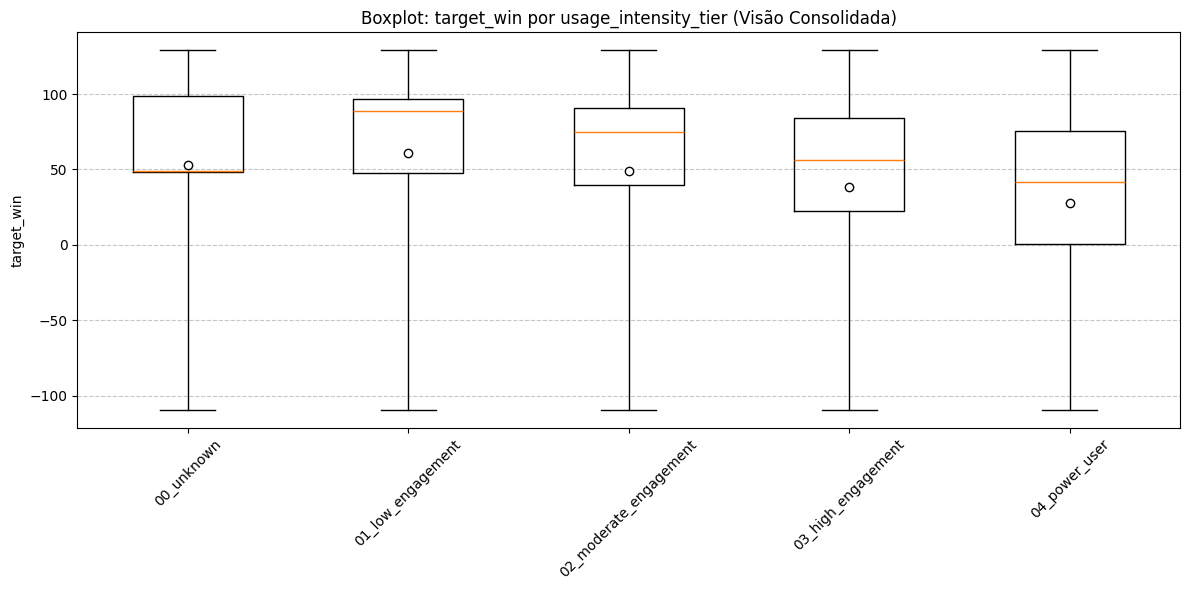


--- Estatísticas: usage_intensity_tier (Visão Consolidada) ---


,usage_intensity_tier,min,q1,med,mean,q3,max
1,00_unknown,-109.315469,48.190266,49.000000,52.748234,98.881314,129.051366
0,01_low_engagement,-109.315469,47.757770,88.952823,60.821331,96.750829,129.051366
4,02_moderate_engagement,-109.315469,39.784859,74.811358,49.308118,90.506625,129.051366
3,03_high_engagement,-109.315469,22.444884,56.542948,38.381403,84.055290,129.051366
2,04_power_user,-109.315469,0.597280,41.908183,28.040117,75.818896,129.051366


In [ ]:
plot_boxplot(df_teste, ["usage_intensity_tier"], "target_win", agrupar_por_safra=False, table=True)

A variável `usage_intensity_tier` foi construída a partir da normalização do volume médio de plays pelo tempo de vida do cliente, sendo posteriormente discretizada em faixas de engajamento. A análise revelou uma relação monotônica clara entre intensidade de uso e margem líquida: usuários com menor engajamento apresentaram as maiores medianas de margem, enquanto usuários classificados como power users apresentaram margens significativamente menores.

Essa evidência confirma o racional de custo operacional do negócio, onde maior intensidade de consumo implica maior custo variável. A discretização em tiers permite capturar essa relação não-linear de forma eficiente em modelos lineares, sendo mantida como uma das principais features do modelo.

### 10.5.4. Conclusao

In [ ]:
# Winsorizar pra cima, no p995 - nao usar valor bruto
p995_int_per_ten = df_final_vars.approxQuantile("usage_intensity_per_tenure", [0.995], 0.001)[0]
df_final_vars = df_final_vars.withColumn("usage_intensity_per_tenure_cap",
    F.when(F.col("usage_intensity_per_tenure") > p995_int_per_ten, p995_int_per_ten).otherwise(F.col("usage_intensity_per_tenure")))

# Tratar os casos de nulos
df_final_vars = df_final_vars.withColumn("usage_intensity_per_tenure_cap",
    F.when(F.col("usage_intensity_per_tenure_cap").isNull(), 0.0).otherwise(F.col("usage_intensity_per_tenure_cap")))

In [ ]:
percentiles_usage_intensity = df_final_vars.stat.approxQuantile("usage_intensity_per_tenure", [0.25, 0.5, 0.75], 0.001)
p25_ui, p50_ui, p75_ui = percentiles_usage_intensity[0], percentiles_usage_intensity[1], percentiles_usage_intensity[2]

df_final_vars = df_final_vars.withColumn("usage_intensity_tier",
    F.when(F.col("usage_intensity_per_tenure").isNull(), "00_unknown")
    .when(F.col("usage_intensity_per_tenure") <= p25_ui, "01_low_engagement")
    .when(F.col("usage_intensity_per_tenure") <= p50_ui, "02_moderate_engagement")
    .when(F.col("usage_intensity_per_tenure") <= p75_ui, "03_high_engagement")
    .otherwise("04_power_user"))

df_final_vars = df_final_vars.drop("usage_intensity_per_tenure")

## 10.6. payment_engagement_gap

### 10.6.1. Definição

Gap de Adimplência vs. Engajamento. Mde a coerência entre pagar e usar através da diferença (não ratio) entre:

- `flag_has_transactions_mean_6`: Taxa de meses com pagamento nos últimos 6 meses (0 a 1);
- `flag_has_logs_mean_6`: Taxa de meses com atividade nos últimos 6 meses (0 a 1).

$$
\text{payment\_engagement\_gap} = \text{flag\_has\_transactions\_mean\_6} - \text{flag\_has\_logs\_mean\_6}
$$

**Por que diferença e não ratio?**
- Ambas as variáveis estão em [0,1], então a diferença fica em [-1, 1], bem comportada.
- Ratio tipo `transactions/logs` explode quando `logs ≈ 0` e perde interpretabilidade.
- A diferença tem significado direto e simétrico.

**Interpretação de Valores**

| Valor | Perfil | Impacto na Margem |
|-------|--------|-------------------|
| **Positivo (+0.5 a +1.0)** | Assinante Fantasma: paga mas não usa | 🟢 Margem Líquida Máxima (receita sem custo) |
| **Zero (~0)** | Usuário Coerente: paga quando usa | 🟡 Margem Saudável |
| **Negativo (-0.5 a -1.0)** | Inadimplente Ativo: usa mas não paga | 🔴 Prejuízo Operacional (custo sem receita) |

### 10.6.2. Construção

In [ ]:
df_final_vars = df_final_vars.withColumn("payment_engagement_gap",
    # Garantir que é proporção válida
    F.when((F.col("flag_has_transactions_mean_6") >= 0) & (F.col("flag_has_transactions_mean_6") <= 1) &
        (F.col("flag_has_logs_mean_6") >= 0) & (F.col("flag_has_logs_mean_6") <= 1),
        F.col("flag_has_transactions_mean_6") - F.col("flag_has_logs_mean_6")).otherwise(None))

### 10.6.3. _Fast EDA_

#### Descritivas + Correlação

In [ ]:
df_final_vars.select("payment_engagement_gap").summary("count", "mean", "stddev", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+----------------------+
|summary|payment_engagement_gap|
+-------+----------------------+
|  count|               8242914|
|   mean|  -0.01359031931345291|
| stddev|   0.11419972603654696|
|    min|   -0.8333333333333334|
|     1%|                  -0.5|
|     5%|  -0.16666666666666666|
|    25%|                   0.0|
|    50%|                   0.0|
|    75%|                   0.0|
|    95%|                   0.0|
|  99.5%|                   0.5|
|    max|    0.8333333333333334|
+-------+----------------------+



A variável “degenerou” em uma quase-constante. Com isso, entende-se que:

* `flag_has_transactions_mean_6` ≈ `flag_has_logs_mean_6`; ou
* as duas flags são 0 no mesmo conjunto de meses, então a diferença dá 0 - que é o mais provável.

In [ ]:
df_final_vars.select("payment_engagement_gap", "target").corr("payment_engagement_gap", "target")

0.032055136576022276

In [ ]:
df_final_vars.select("payment_engagement_gap", "target_win").corr("payment_engagement_gap", "target_win")

0.05645751160251486

Sinal até existe, mas é fraco. Talvez faca mais sentido trabalhar com flags que separam _ghost payers_ (paga com frequência, mas quase não usa) de _freeloaders_ (usa com frequência, mas quase não paga).

#### Flag

In [ ]:
tx = F.col("flag_has_transactions_mean_6")
lg = F.col("flag_has_logs_mean_6")

valid = (tx.between(0, 1)) & (lg.between(0, 1))

In [ ]:
df_teste = (df_final_vars
    .withColumn("flag_ghost_payer_6m", F.when(valid & (tx >= 0.5) & (lg <= 0.1666666667), 1).otherwise(0))
    .withColumn("flag_freeloader_6m", F.when(valid & (lg >= 0.5) & (tx <= 0.1666666667), 1).otherwise(0))
)

In [ ]:
calcular_distribuicao(df_teste, ["flag_ghost_payer_6m"])

+-------------------+--------+---------+
|flag_ghost_payer_6m|total   |pct_total|
+-------------------+--------+---------+
|0                  |11220683|99.8     |
|1                  |22182   |0.2      |
+-------------------+--------+---------+



DataFrame[flag_ghost_payer_6m: int, total: bigint, pct_total: double]

In [ ]:
calcular_distribuicao(df_teste, ["flag_freeloader_6m"])

+------------------+--------+---------+
|flag_freeloader_6m|total   |pct_total|
+------------------+--------+---------+
|0                 |11203945|99.65    |
|1                 |38920   |0.35     |
+------------------+--------+---------+



DataFrame[flag_freeloader_6m: int, total: bigint, pct_total: double]

### 10.6.4. Conclusao

Alem da raw, foram avaliadas flags destinadas a identificar perfis extremos de comportamento — usuários que utilizam o serviço sem pagar (freeloaders) e usuários que pagam sem utilizar (ghost payers). A análise revelou que tais perfis representam menos de 0.5% da base total, resultando em variáveis altamente esparsas e com forte _zero-inflation_.

Devido ao baixíssimo suporte estatístico, essas variáveis apresentam impacto global irrelevante na performance do modelo, além de elevado risco de instabilidade temporal e overfitting. Adicionalmente, o racional econômico subjacente a esses perfis já é capturado de forma mais robusta por variáveis contínuas e categóricas de engajamento e intensidade de uso.

Desconsiderar.

In [ ]:
df_final_vars = df_final_vars.drop("payment_engagement_gap")

## 10.7. revenue_volatility_6m

### 10.7.1 Definição

Volatilidade de Receita. Captura a instabilidade financeira do cliente através da amplitude relativa da receita diária nos últimos 6 meses.

$$
\text{revenue\_volatility\_6m} = \frac{\text{daily\_revenue\_efficiency\_max\_6} - \text{daily\_revenue\_efficiency\_min\_6}}{\text{daily\_revenue\_efficiency\_mean\_6} + 1}
$$

- **Numerador:** Amplitude (max - min) da receita diária.
- **Denominador:** Receita média + 1 (para evitar divisão por zero e normalizar).

**Por que isso importa?**
- Alta volatilidade indica mudanças frequentes de plano (_downgrades_/_upgrades_) ou alternância entre pagamento e isenção.
- Clientes voláteis têm maior probabilidade de churn e margem imprevisível.

**Interpretação de Valores**

| Valor | Perfil | Impacto na Margem |
|-------|--------|-------------------|
| **Alto (>1.0)** | Instável: alterna entre planos ou isenções | 🔴 Margem Imprevisível, Alto Risco de _Churn_ |
| **Médio (0.3-1.0)** | Moderadamente Estável | 🟡 Risco Moderado |
| **Baixo (<0.3)** | Estável: mantém o mesmo plano | 🟢 Margem Previsível, Baixo Risco |


### 10.7.2. Construção

In [ ]:
df_final_vars = df_final_vars.withColumn("revenue_volatility_6m",
    F.when((F.col("daily_revenue_efficiency_max_6") >= 0) & (F.col("daily_revenue_efficiency_min_6") >= 0) & (F.col("daily_revenue_efficiency_mean_6") >= 0),
        (F.col("daily_revenue_efficiency_max_6") - F.col("daily_revenue_efficiency_min_6")) / (F.col("daily_revenue_efficiency_mean_6") + 1))
    .otherwise(None))

### 10.7.3. _Fast EDA_

#### Descritivas + Correlação

In [ ]:
df_final_vars.select("revenue_volatility_6m").summary("count", "mean", "stddev", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+---------------------+
|summary|revenue_volatility_6m|
+-------+---------------------+
|  count|              8623297|
|   mean|  0.13452032837706035|
| stddev|   0.5937154978488456|
|    min|                  0.0|
|     1%|                  0.0|
|     5%|                  0.0|
|    25%|                  0.0|
|    50%|                  0.0|
|    75%|                  0.0|
|    95%|   0.9664864864864864|
|  99.5%|    4.805560704355885|
|    max|    5.936254980079681|
+-------+---------------------+



Pelo menos 75% da base tem volatilidade = 0, indicando que `daily_revenue_efficiency_max_6` = `daily_revenue_efficiency_min_6` (receita constante nos 6 meses). A variável só "acende" para os 5% superiores

In [ ]:
df_final_vars.select("revenue_volatility_6m", "target").corr("revenue_volatility_6m", "target")

0.0600087999847909

In [ ]:
df_final_vars.select("revenue_volatility_6m", "target_win").corr("revenue_volatility_6m", "target_win")

0.08424592298389764

### 10.7.4. Conclusao

Embora a variável apresente correlação positiva com a target, indicando que volatilidade pode capturar upgrades de plano, a magnitude do efeito é insuficiente para justificar sua inclusão. Adicionalmente, o racional de instabilidade financeira já é capturado de forma mais robusta por variáveis de isenção (`flag_exemption_mean_6`) e eficiência de receita (`revenue_per_hour_tier`). Descartar.

In [ ]:
df_final_vars = df_final_vars.drop("revenue_volatility_6m")

## 10.8. Salvando base com todos os _books_ + _cross-domain features_

In [ ]:
df_final_vars.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- num_25: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- num_75: double (nullable = true)
 |-- num_985: double (nullable = true)
 |-- num_100: double (nullable = true)
 |-- num_unq: double (nullable = true)
 |-- total_secs: double (nullable = true)
 |-- total_plays: double (nullable = true)
 |-- flag_has_logs: integer (nullable = true)
 |-- total_plays_group: string (nullable = true)
 |-- log_total_plays: double (nullable = true)
 |-- completed_songs_rate: double (nullable = true)
 |-- completed_songs_rate_group: string (nullable = true)
 |-- avg_secs_per_unq: double (nullable = true)
 |-- avg_secs_per_unq_cap: double (nullable = true)
 |-- avg_secs_per_unq_cap_group: string (nullable = true)
 |-- log_avg_secs_per_unq: double (nullable = true)
 |-- plays_per_unq: double (nullable = true)
 |-- plays_per_unq_cap: double (nullable = true)
 |-- plays_per_unq_behavior: string (nullable = t

In [ ]:
df_final_vars.filter(F.col("margem_liquida_mensal").isNull()).count()

0

In [ ]:
df_final_vars.filter(F.col("target").isNull()).count()

1563999

In [ ]:
df_final_vars.filter(F.col("target_win").isNull()).count()

1563999

In [ ]:
df_final_vars.filter(F.col("target_win").isNull()).groupBy("safra").count().show(5)

+------+------+
| safra| count|
+------+------+
|201605| 34322|
|201610|121953|
|201606| 26707|
|201611|146985|
|201607| 44169|
+------+------+
only showing top 5 rows



In [ ]:
# Se o número de nulos for próximo ao número de msno únicos, o diagnóstico está correto
print(f"Total de nulos no target: {df_final_vars.filter(F.col('target').isNull()).count()}")
print(f"Total de clientes únicos: {df_final_vars.select('msno').distinct().count()}")

Total de nulos no target: 1563999
Total de clientes únicos: 1563999


In [ ]:
# 1. cache
df_final_vars = df_final_vars.persist()
df_final_vars.count()

# 2. salvar particionado
df_final_vars.write \
    .mode("overwrite") \
    .partitionBy("safra") \
    .parquet("C:/Users/Gustavo/Downloads/datamaster/dados/silver/df_feature_store_intermediate")